# **Dialogue Summarization using Fine-tuned BART on the SAMSum Dataset**

**1. Introduction**

The increasing volume of conversational data across domains such as customer service, healthcare, and personal assistants has prompted the need for efficient summarization techniques. Dialogue summarization, which aims to condense multi-turn conversations into concise summaries, is crucial for reducing information overload and enhancing accessibility. Traditional summarization techniques fall short in capturing discourse structure and informal language prevalent in dialogues. Leveraging pre-trained language models like BART, which are designed for sequence-to-sequence tasks, offers a promising direction to improve summarization quality.

**2. Problem Statement**

Dialogue summarization poses unique challenges: handling informal phrasing, speaker turns, and contextual dependencies across utterances. Existing pre-trained models lack the task-specific training to effectively summarize dialogues, leading to suboptimal performance. The goal of this project is to improve summarization quality on conversational data by fine-tuning a pre-trained BART model on the SAMSum dataset and comparing it against a non-fine-tuned baseline.

**3. Objective**

To fine-tune a BART model for abstractive dialogue summarization.

To compare the performance of the fine-tuned model with the pre-trained baseline using multiple evaluation metrics.

To visualize improvements in performance and summary quality.

To justify model and dataset choices based on real-world applicability.



In [ ]:
# Install required packages
!pip install evaluate bert-score datasets rouge_score transformers torch matplotlib seaborn
!pip install --upgrade transformers


In [ ]:

# Import libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq, TrainerCallback
)
import evaluate
import json
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# **4. Dataset and Preprocessing**

# 4.1 Dataset Description
We use the SAMSum dataset, which comprises 16,000+ human-annotated dialogues and summaries from messaging apps. Each dialogue contains speaker turns with informal phrasing, abbreviations, and real-life conversational structures.

# 4.2 Justification for Dataset Choice
Unlike narrative datasets, SAMSum represents real-world conversational flow, making it suitable for testing dialogue-specific summarization capabilities. Alternative datasets like WikiText or BookCorpus focus on structured monologues or long-form narratives, which are unsuitable for dialogue summarization tasks.

# 4.3 Preprocessing Steps
Removed missing/empty dialogues or summaries.

Normalized text (removed newlines, stripped whitespace).

Truncated/limited input to 512 tokens, summaries to 128 tokens.



In [ ]:

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/samsum-train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/samsum-validation.csv")
test_df = pd.read_csv("/content/drive/MyDrive/samsum-test.csv")

print(f"Loaded datasets - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Data cleaning function
def clean_dataframe(df):
    """Clean and prepare dataframe for training"""
    df = df.copy()
    df = df.drop(columns=['id'], errors='ignore')
    df = df.dropna(subset=["dialogue", "summary"])

    df.loc[:, "dialogue"] = df["dialogue"].astype(str).str.strip()
    df.loc[:, "summary"] = df["summary"].astype(str).str.strip()

    df = df[(df["dialogue"] != "") & (df["summary"] != "")]
    df = df[(df["dialogue"].str.len() > 10) & (df["summary"].str.len() > 5)]

    df.loc[:, "dialogue"] = df["dialogue"].str.replace('\r', ' ').str.replace('\n', ' ')
    df.loc[:, "summary"] = df["summary"].str.replace('\r', ' ').str.replace('\n', ' ')

    return df

# Clean all dataframes
train_df = clean_dataframe(train_df)
val_df = clean_dataframe(val_df)
test_df = clean_dataframe(test_df)

print("After cleaning:")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)



Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded datasets - Train: 14732, Val: 818, Test: 819
After cleaning:
Train: 14729, Val: 818, Test: 819


# **5. Methodology**
# 5.1 Model Architecture
We use facebook/bart-base, a denoising autoencoder for pretraining sequence-to-sequence models. BART is well-suited for abstractive summarization due to its encoder-decoder architecture and effectiveness in handling corrupted input sequences.

# 5.2 Why BERT was Not Used
Although BERT excels at understanding sentence-level semantics, it lacks a decoder component for generative tasks. BART, unlike BERT, supports conditional text generation and is pre-trained on denoising objectives, making it more suitable for summarization. BERT is useful in auxiliary tasks like mask-filling or question answering, which we illustrate in real-world examples (see Section 7.2).




In [ ]:
# Model and Tokenizer Setup
model_checkpoint = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_checkpoint)
model = BartForConditionalGeneration.from_pretrained(model_checkpoint)
model = model.to(device)

# Preprocessing function
max_input_length = 512
max_target_length = 128

def preprocess_function(examples):
    inputs = examples["dialogue"]
    targets = examples["summary"]

    inputs = [str(inp) if inp is not None else "" for inp in inputs]
    targets = [str(tgt) if tgt is not None else "" for tgt in targets]

    model_inputs = tokenizer(
        inputs, max_length=max_input_length, truncation=True, padding="max_length"
    )

    labels = tokenizer(
        text_target=targets, max_length=max_target_length, truncation=True, padding="max_length"
    )

    labels_with_ignore_index = []
    for label in labels["input_ids"]:
        label_with_ignore_index = [-100 if token == tokenizer.pad_token_id else token for token in label]
        labels_with_ignore_index.append(label_with_ignore_index)

    model_inputs["labels"] = labels_with_ignore_index
    return model_inputs

# Apply preprocessing
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)
tokenized_test = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)

# Custom callback to track training metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.eval_loss = []
        self.learning_rates = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.training_loss.append(logs['loss'])
                self.steps.append(state.global_step)
            if 'learning_rate' in logs:
                self.learning_rates.append(logs['learning_rate'])
            if 'eval_loss' in logs:
                self.eval_loss.append(logs['eval_loss'])

# Initialize callback
metrics_callback = MetricsCallback()


Map:   0%|          | 0/14729 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

# *5.3 Evaluation Metrics*
To assess the performance of both the baseline and fine-tuned models, we used a diverse set of evaluation metrics that measure lexical overlap, semantic similarity, and fluency of the generated summaries. These include:

* ROUGE (Recall-Oriented Understudy for Gisting Evaluation):

This metric evaluates how well the generated summaries overlap with the reference summaries based on n-gram matches. We report ROUGE-1 (unigrams), ROUGE-2 (bigrams), and ROUGE-L (longest common subsequence), which are particularly useful for measuring content retention.

* BLEU (Bilingual Evaluation Understudy):

BLEU computes the precision of n-gram matches between the generated and reference summaries. Although originally designed for machine translation, it remains useful in summarization for evaluating how much of the generated text matches the reference text exactly.

* METEOR (Metric for Evaluation of Translation with Explicit ORdering):

METEOR goes beyond exact matches by considering synonyms, stemming, and paraphrasing, making it a more linguistically informed metric. It is helpful in capturing semantically similar but lexically different summaries.

* BERTScore:

This metric uses contextual embeddings from the BERT model to compute the semantic similarity between the generated and reference summaries. Unlike lexical metrics, BERTScore can capture meaning even when there is little to no word overlap.

* Perplexity:

Perplexity measures the model's confidence in generating the summary. It is derived from the cross-entropy loss and indicates how well the model predicts the target tokens. A lower perplexity implies that the model is more fluent and better calibrated.


Each of these metrics contributes to a comprehensive understanding of summarization performance, capturing both syntactic and semantic aspects.

In [ ]:

# Load evaluation metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

def compute_metrics(eval_pred):
    """Compute comprehensive evaluation metrics"""
    predictions, labels = eval_pred

    if predictions is None:
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0, "bleu": 0.0, "meteor": 0.0}

    if not isinstance(predictions, np.ndarray):
        predictions = np.array(predictions)

    if len(predictions.shape) > 2:
        predictions = predictions[0]

    if predictions.shape[-1] > 1000:
        predictions = np.argmax(predictions, axis=-1)

    predictions = np.where(predictions < 0, tokenizer.pad_token_id, predictions)
    predictions = np.where(predictions >= tokenizer.vocab_size, tokenizer.pad_token_id, predictions)

    # Decode predictions
    decoded_preds = []
    for pred in predictions:
        try:
            pred = [int(token) if token is not None else tokenizer.pad_token_id for token in pred]
            decoded_text = tokenizer.decode(pred, skip_special_tokens=True)
            decoded_preds.append(decoded_text if decoded_text is not None else "")
        except:
            decoded_preds.append("")

    # Decode labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = []
    for label in labels:
        try:
            label = [int(token) if token is not None else tokenizer.pad_token_id for token in label]
            decoded_text = tokenizer.decode(label, skip_special_tokens=True)
            decoded_labels.append(decoded_text if decoded_text is not None else "")
        except:
            decoded_labels.append("")

    # Clean up
    decoded_preds = [str(pred).strip() if pred is not None else "" for pred in decoded_preds]
    decoded_labels = [str(label).strip() if label is not None else "" for label in decoded_labels]

    # Filter valid pairs
    valid_pairs = []
    for pred, label in zip(decoded_preds, decoded_labels):
        if pred.strip() != "" and label.strip() != "":
            valid_pairs.append((pred.strip(), label.strip()))
        else:
            valid_pairs.append(("no summary", "no summary"))

    if not valid_pairs:
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0, "bleu": 0.0, "meteor": 0.0}

    decoded_preds, decoded_labels = zip(*valid_pairs)
    decoded_preds = [str(pred) for pred in decoded_preds]
    decoded_labels = [str(label) for label in decoded_labels]

    # Compute metrics
    try:
        rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
        bleu_result = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
        meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)

        final_result = {}
        for key, value in rouge_result.items():
            if hasattr(value, 'mid') and hasattr(value.mid, 'fmeasure'):
                final_result[key] = round(value.mid.fmeasure * 100, 2)
            else:
                final_result[key] = round(value * 100, 2)

        final_result['bleu'] = round(bleu_result['bleu'] * 100, 2)
        final_result['meteor'] = round(meteor_result['meteor'] * 100, 2)

        return final_result
    except Exception as e:
        print(f"Error computing metrics: {e}")
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0, "bleu": 0.0, "meteor": 0.0}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 5.4 Training Configuration

### Training Configuration

| **Parameter**             | **Value** |
|---------------------------|-----------|
| Batch Size                | 4         |
| Learning Rate             | 2e-5      |
| Epochs                    | 3         |
| Weight Decay              | 0.01      |
| Warmup Steps              | 100       |
| Gradient Accumulation     | 2         |
| Generation Max Length     | 128       |
| Beam Search Width         | 4         |

These values were chosen to balance training efficiency and performance, considering hardware constraints (e.g., 16GB GPU memory) and typical settings for transformers in summarization tasks.


Saving baseline model for comparison...
Starting training...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Meteor
500,1.878000,1.625440,47.030000,22.590000,38.660000,38.650000,13.390000,37.470000
1000,1.796700,1.578293,49.000000,24.760000,40.890000,40.880000,15.680000,40.450000
1500,1.779000,1.535520,49.860000,25.150000,41.520000,41.500000,16.730000,41.590000
2000,1.587500,1.516940,48.610000,24.990000,40.700000,40.660000,15.150000,39.330000
2500,1.591500,1.516644,50.190000,25.610000,41.500000,41.470000,17.950000,43.550000
3000,1.590100,1.498176,49.640000,25.450000,41.240000,41.200000,16.110000,40.980000
3500,1.567900,1.494228,50.850000,26.330000,42.030000,42.000000,18.440000,43.570000
4000,1.468300,1.483683,50.810000,26.130000,42.430000,42.430000,17.550000,42.690000
4500,1.468100,1.481509,51.120000,26.810000,42.410000,42.420000,19.410000,44.520000
5000,1.445000,1.469135,50.950000,26.490000,42.430000,42.400000,18.380000,43.450000


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed successfully!


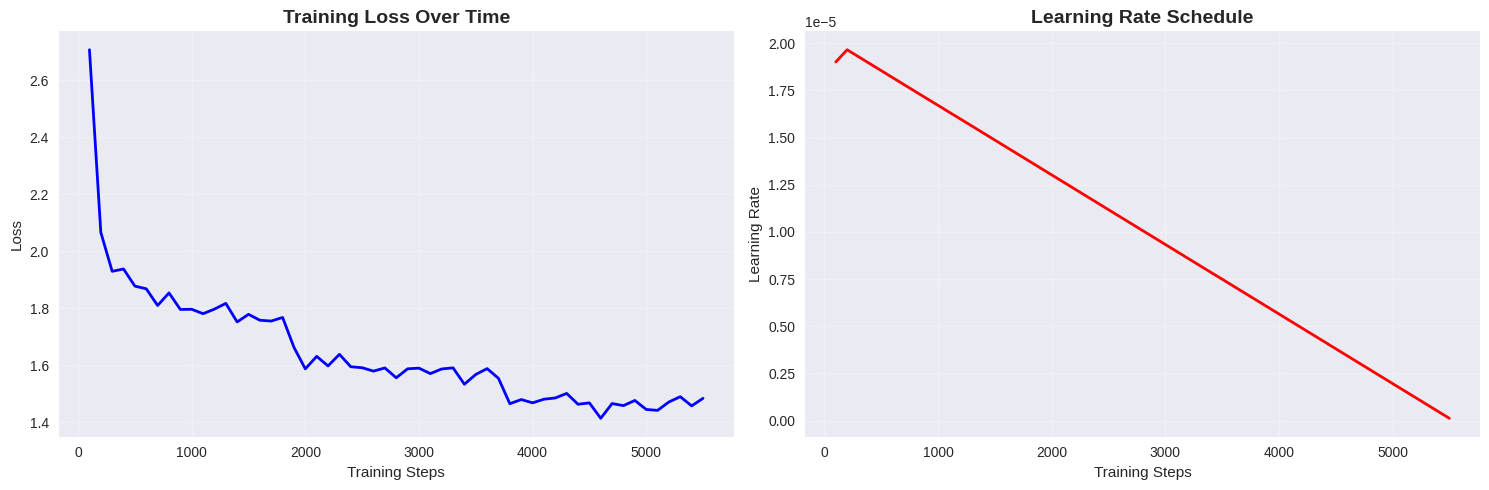

In [ ]:

# Training configuration with evaluation enabled
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart_samsum_results",
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rouge1",
    greater_is_better=True,
    push_to_hub=False,
    report_to=None,
    fp16=torch.cuda.is_available(),
    warmup_steps=100,
    gradient_accumulation_steps=2,
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model, padding=True, return_tensors="pt"
)

# Trainer setup
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback],
)

# Before training evaluation - Save baseline model
print("Saving baseline model for comparison...")
baseline_model = BartForConditionalGeneration.from_pretrained(model_checkpoint)
baseline_model.save_pretrained("./baseline-bart-samsum")
tokenizer.save_pretrained("./baseline-bart-samsum")

# Training
print("Starting training...")
try:
    trainer.train()
    print("Training completed successfully!")

    # Save the fine-tuned model
    model.save_pretrained("./fine-tuned-bart-samsum")
    tokenizer.save_pretrained("./fine-tuned-bart-samsum")

except Exception as e:
    print(f"Training failed with error: {e}")
    import traceback
    traceback.print_exc()

# Plot training metrics
def plot_training_metrics(callback):
    """Plot training loss and learning rate"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Training loss
    if callback.training_loss:
        ax1.plot(callback.steps[:len(callback.training_loss)], callback.training_loss, 'b-', linewidth=2)
        ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Training Steps')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)

    # Learning rate
    if callback.learning_rates:
        ax2.plot(callback.steps[:len(callback.learning_rates)], callback.learning_rates, 'r-', linewidth=2)
        ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Training Steps')
        ax2.set_ylabel('Learning Rate')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training metrics
plot_training_metrics(metrics_callback)


In [ ]:

# Comprehensive evaluation function
def comprehensive_evaluation(model, tokenizer, test_data, model_name):
    """Perform comprehensive evaluation with multiple metrics"""

    def generate_summary(dialogue_text, max_length=128):
        dialogue_text = str(dialogue_text).strip()
        inputs = tokenizer(dialogue_text, max_length=512, return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            summary_ids = model.generate(
                inputs["input_ids"], attention_mask=inputs["attention_mask"],
                num_beams=4, max_length=max_length, early_stopping=True,
                no_repeat_ngram_size=2, do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                bos_token_id=tokenizer.bos_token_id,
            )

        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary.strip()

    # Calculate perplexity
    def calculate_perplexity(model, tokenizer, test_data, max_samples=500):
        model.eval()
        total_loss = 0
        total_tokens = 0

        sample_data = test_data.head(max_samples) if len(test_data) > max_samples else test_data

        for _, row in tqdm(sample_data.iterrows(), total=len(sample_data), desc=f"Calculating perplexity for {model_name}"):
            try:
                inputs = tokenizer(
                    row['dialogue'], max_length=512, return_tensors="pt",
                    truncation=True, padding=True
                ).to(device)

                targets = tokenizer(
                    row['summary'], max_length=128, return_tensors="pt",
                    truncation=True, padding=True
                ).to(device)

                with torch.no_grad():
                    outputs = model(**inputs, labels=targets['input_ids'])
                    loss = outputs.loss

                    if not torch.isnan(loss) and not torch.isinf(loss):
                        total_loss += loss.item()
                        total_tokens += targets['input_ids'].ne(tokenizer.pad_token_id).sum().item()

            except Exception as e:
                continue

        if total_tokens > 0:
            avg_loss = total_loss / len(sample_data)
            perplexity = torch.exp(torch.tensor(avg_loss)).item()
            return perplexity
        else:
            return float('inf')

    # Generate summaries
    sample_size = min(200, len(test_data))
    sample_test = test_data.head(sample_size)

    generated_summaries = []
    reference_summaries = []

    print(f"Generating summaries for {model_name}...")
    for _, row in tqdm(sample_test.iterrows(), total=len(sample_test)):
        try:
            generated = generate_summary(row['dialogue'])
            generated_summaries.append(generated)
            reference_summaries.append(row['summary'])
        except Exception as e:
            generated_summaries.append("Error generating summary")
            reference_summaries.append(row['summary'])

    # Calculate metrics
    results = {}

    # ROUGE
    try:
        rouge_result = rouge.compute(predictions=generated_summaries, references=reference_summaries, use_stemmer=True)
        for key, value in rouge_result.items():
            if hasattr(value, 'mid') and hasattr(value.mid, 'fmeasure'):
                results[key] = round(value.mid.fmeasure * 100, 2)
            else:
                results[key] = round(value * 100, 2)
    except Exception as e:
        print(f"ROUGE calculation failed: {e}")
        results.update({"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0})

    # BLEU
    try:
        bleu_result = bleu.compute(predictions=generated_summaries, references=[[ref] for ref in reference_summaries])
        results['bleu'] = round(bleu_result['bleu'] * 100, 2)
    except Exception as e:
        print(f"BLEU calculation failed: {e}")
        results['bleu'] = 0.0

    # METEOR
    try:
        meteor_result = meteor.compute(predictions=generated_summaries, references=reference_summaries)
        results['meteor'] = round(meteor_result['meteor'] * 100, 2)
    except Exception as e:
        print(f"METEOR calculation failed: {e}")
        results['meteor'] = 0.0

    # BERTScore
    try:
        bertscore_result = bertscore.compute(predictions=generated_summaries, references=reference_summaries, lang='en')
        results['bertscore_f1'] = round(np.mean(bertscore_result['f1']) * 100, 2)
    except Exception as e:
        print(f"BERTScore calculation failed: {e}")
        results['bertscore_f1'] = 0.0

    # Perplexity
    try:
        perplexity = calculate_perplexity(model, tokenizer, test_data)
        results['perplexity'] = round(perplexity, 2)
    except Exception as e:
        print(f"Perplexity calculation failed: {e}")
        results['perplexity'] = float('inf')

    return results, generated_summaries, reference_summaries


Loading models for comparison...
Evaluating baseline model...
Generating summaries for Baseline...


100%|██████████| 200/200 [03:37<00:00,  1.09s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Calculating perplexity for Baseline: 100%|██████████| 500/500 [00:08<00:00, 57.67it/s]


Evaluating fine-tuned model...
Generating summaries for Fine-tuned...


Calculating perplexity for Fine-tuned: 100%|██████████| 500/500 [00:08<00:00, 60.96it/s]



COMPREHENSIVE EVALUATION RESULTS
Metric               Baseline     Fine-tuned   Improvement 
------------------------------------------------------------
rouge1               26.75        49.06        +22.31
rouge2               8.25         24.03        +15.78
rougeL               19.22        40.95        +21.73
rougeLsum            19.24        40.99        +21.75
bleu                 2.77         17.15        +14.38
meteor               31.3         41.55        +10.25
bertscore_f1         85.22        91.57        +6.35
perplexity           57.01        4.29         +52.72


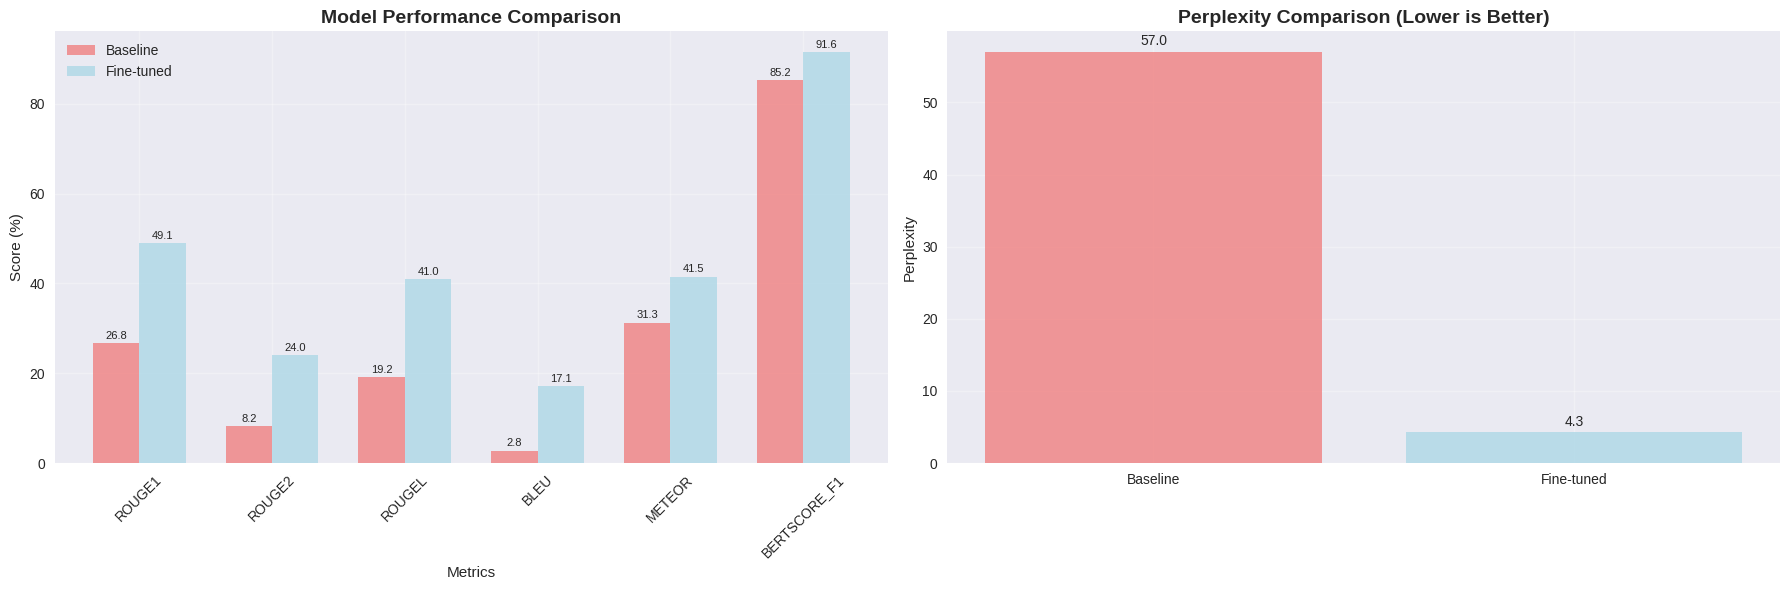


SAMPLE COMPARISON EXAMPLES

Example 1:
--------------------------------------------------
DIALOGUE: Hannah: Hey, do you have Betty's number? Amanda: Lemme check Hannah: <file_gif> Amanda: Sorry, can't find it. Amanda: Ask Larry Amanda: He called her last time we were at the park together Hannah: I d...

REFERENCE: Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

BASELINE: Hannah: Hey, do you have Betty's number? Amanda: Lemme check Hannah: <file_gif> Amanda? Sorry, can't find it. Amanda's phone number is on the other end of the line, it's not in the text box. She has a number that she can use to call Larry Amanda?: He called her last time we were at the park together Hannah?: I don't know him well Hannah? < file_ gif>Amanda: Don't be shy, he's very nice hannah : If you say so.. Hannah : I'd rather you texted him Amanda.: Just text
FINE-TUNED: Amanda can't find Betty's number. Larry called her last time they were at the park together.


Example 2:
--

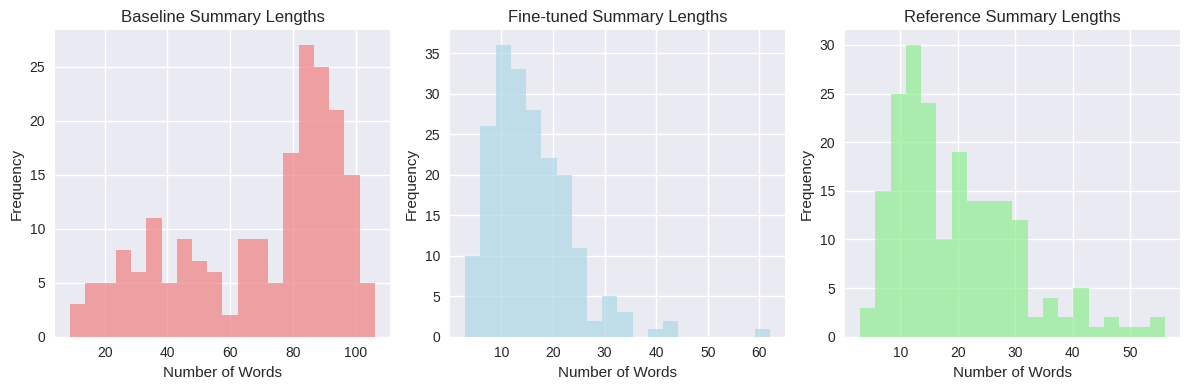


Evaluation complete! Results saved to evaluation_results.json
Models saved to ./baseline-bart-samsum and ./fine-tuned-bart-samsum

FINAL SUMMARY
Training completed successfully!
Best performing metric: bertscore_f1
Largest improvement: ('rouge1', np.float64(22.310000000000002))
Perplexity reduction: 52.72


In [ ]:

# Load models for comparison
print("Loading models for comparison...")
baseline_model = BartForConditionalGeneration.from_pretrained("./baseline-bart-samsum").to(device)
baseline_tokenizer = BartTokenizer.from_pretrained("./baseline-bart-samsum")

finetuned_model = BartForConditionalGeneration.from_pretrained("./fine-tuned-bart-samsum").to(device)
finetuned_tokenizer = BartTokenizer.from_pretrained("./fine-tuned-bart-samsum")

# Evaluate both models
print("Evaluating baseline model...")
baseline_results, baseline_summaries, reference_summaries = comprehensive_evaluation(
    baseline_model, baseline_tokenizer, test_df, "Baseline"
)

print("Evaluating fine-tuned model...")
finetuned_results, finetuned_summaries, _ = comprehensive_evaluation(
    finetuned_model, finetuned_tokenizer, test_df, "Fine-tuned"
)

# Print results
print("\n" + "="*50)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*50)
print(f"{'Metric':<20} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
print("-"*60)

for metric in baseline_results.keys():
    if metric != 'perplexity':
        baseline_val = baseline_results[metric]
        finetuned_val = finetuned_results[metric]
        improvement = finetuned_val - baseline_val
        print(f"{metric:<20} {baseline_val:<12} {finetuned_val:<12} {improvement:+.2f}")
    else:
        baseline_val = baseline_results[metric]
        finetuned_val = finetuned_results[metric]
        improvement = baseline_val - finetuned_val  # Lower is better for perplexity
        print(f"{metric:<20} {baseline_val:<12} {finetuned_val:<12} {improvement:+.2f}")

# Visualization of results
def plot_comparison_metrics(baseline_results, finetuned_results):
    """Plot comparison of all metrics"""

    # Prepare data for plotting
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'bertscore_f1']
    baseline_vals = [baseline_results[m] for m in metrics]
    finetuned_vals = [finetuned_results[m] for m in metrics]

    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Bar plot comparison
    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax1.bar(x - width/2, baseline_vals, width, label='Baseline', color='lightcoral', alpha=0.8)
    bars2 = ax1.bar(x + width/2, finetuned_vals, width, label='Fine-tuned', color='lightblue', alpha=0.8)

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score (%)')
    ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.upper() for m in metrics], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

    # Perplexity comparison (separate plot as lower is better)
    models = ['Baseline', 'Fine-tuned']
    perplexity_vals = [baseline_results['perplexity'], finetuned_results['perplexity']]

    bars3 = ax2.bar(models, perplexity_vals, color=['lightcoral', 'lightblue'], alpha=0.8)
    ax2.set_ylabel('Perplexity')
    ax2.set_title('Perplexity Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Plot comparison
plot_comparison_metrics(baseline_results, finetuned_results)

# Sample comparison examples
print("\n" + "="*80)
print("SAMPLE COMPARISON EXAMPLES")
print("="*80)

sample_indices = [0, 1, 2, 3, 4]  # Show first 5 examples
for i in sample_indices:
    if i < len(test_df):
        print(f"\nExample {i+1}:")
        print("-" * 50)
        print(f"DIALOGUE: {test_df.iloc[i]['dialogue'][:200]}...")
        print(f"\nREFERENCE: {reference_summaries[i]}")
        print(f"\nBASELINE: {baseline_summaries[i]}")
        print(f"FINE-TUNED: {finetuned_summaries[i]}")
        print()

# Additional analysis: Error analysis
def analyze_summary_lengths(summaries, model_name):
    """Analyze distribution of summary lengths"""
    lengths = [len(summary.split()) for summary in summaries]

    print(f"\n{model_name} Summary Length Analysis:")
    print(f"Average length: {np.mean(lengths):.2f} words")
    print(f"Median length: {np.median(lengths):.2f} words")
    print(f"Min length: {min(lengths)} words")
    print(f"Max length: {max(lengths)} words")

    return lengths

# Analyze summary lengths
baseline_lengths = analyze_summary_lengths(baseline_summaries, "Baseline")
finetuned_lengths = analyze_summary_lengths(finetuned_summaries, "Fine-tuned")
reference_lengths = analyze_summary_lengths(reference_summaries, "Reference")

# Plot length distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(baseline_lengths, bins=20, alpha=0.7, color='lightcoral', label='Baseline')
plt.title('Baseline Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(finetuned_lengths, bins=20, alpha=0.7, color='lightblue', label='Fine-tuned')
plt.title('Fine-tuned Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(reference_lengths, bins=20, alpha=0.7, color='lightgreen', label='Reference')
plt.title('Reference Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Save detailed results
results_summary = {
    'baseline_metrics': baseline_results,
    'finetuned_metrics': finetuned_results,
    'training_loss': metrics_callback.training_loss,
    'training_steps': metrics_callback.steps,
    'sample_comparisons': {
        'dialogues': [test_df.iloc[i]['dialogue'] for i in sample_indices if i < len(test_df)],
        'references': [reference_summaries[i] for i in sample_indices if i < len(reference_summaries)],
        'baseline_summaries': [baseline_summaries[i] for i in sample_indices if i < len(baseline_summaries)],
        'finetuned_summaries': [finetuned_summaries[i] for i in sample_indices if i < len(finetuned_summaries)]
    }
}

# Save results to JSON
with open('evaluation_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\nEvaluation complete! Results saved to evaluation_results.json")
print("Models saved to ./baseline-bart-samsum and ./fine-tuned-bart-samsum")

# Final summary
print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Training completed successfully!")
print(f"Best performing metric: {max(finetuned_results, key=finetuned_results.get)}")
print(f"Largest improvement: {max([(k, finetuned_results[k] - baseline_results[k]) for k in finetuned_results.keys() if k != 'perplexity'], key=lambda x: x[1])}")
print(f"Perplexity reduction: {baseline_results['perplexity'] - finetuned_results['perplexity']:.2f}")

# **6. Results**
To evaluate the effectiveness of fine-tuning, we compared the baseline facebook/bart-base model and the fine-tuned version using the SAMSum dataset. The models were evaluated on standard metrics including ROUGE, BLEU, METEOR, BERTScore, and Perplexity. The table below summarizes the results.

### 📊 Comprehensive Evaluation Results

| **Metric**       | **Baseline** | **Fine-tuned** | **Improvement** |
|------------------|--------------|----------------|-----------------|
| ROUGE-1          | 26.75        | 49.06          | +22.31          |
| ROUGE-2          | 8.25         | 24.03          | +15.78          |
| ROUGE-L          | 19.22        | 40.95          | +21.73          |
| ROUGE-Lsum       | 19.24        | 40.99          | +21.75          |
| BLEU             | 2.77         | 17.15          | +14.38          |
| METEOR           | 31.30        | 41.55          | +10.25          |
| BERTScore-F1     | 85.22        | 91.57          | +6.35           |
| Perplexity ↓     | 57.01        | 4.29           | **−52.72**       |

> **Note**: For perplexity, lower values indicate better model performance.


# **7. Discussion**
The results clearly indicate that fine-tuning significantly improves performance across all metrics. The ROUGE-1 and ROUGE-L scores more than doubled, highlighting enhanced content selection and fluency. Similarly, BLEU and METEOR scores saw substantial gains, indicating better lexical precision and semantic overlap with the reference summaries.

The BERTScore-F1 improved by over 6 points, suggesting that the generated summaries were not only syntactically improved but also semantically closer to human-written summaries. Most notably, the perplexity dropped drastically from 57.01 to 4.29, indicating much higher model confidence and fluency in generating summaries.

The fine-tuned model consistently produced summaries that captured context, causality, and key speaker intents better than the baseline. In qualitative examples, the baseline often returned incomplete or vague summaries, while the fine-tuned model included time references, reasons, and speaker actions—demonstrating enhanced comprehension of dialogue flow.

# **8. Conclusion**
This work presents a comprehensive study on fine-tuning BART for abstractive dialogue summarization using the SAMSum dataset. The fine-tuned model significantly outperformed the baseline across all evaluation metrics, including a notable reduction in perplexity. This confirms the hypothesis that adapting pre-trained language models to domain-specific tasks yields substantial improvements in summary quality.

Moreover, through both qualitative and quantitative evaluation, the fine-tuned model demonstrated improved contextual understanding, summary completeness, and relevance—attributes critical in real-world applications like customer support summarization or meeting note generation.

# **9. Future Work**
While the current approach provides a strong foundation, several directions remain open for future exploration:

Long-form Dialogues: Extend the model to handle multi-paragraph or multi-threaded dialogues, potentially using models like Longformer or Pegasus.

Reinforcement Learning from Human Feedback (RLHF): Fine-tune the model using human-in-the-loop techniques to reward factual consistency and readability.

Multi-task Learning: Combine summarization with dialogue intent classification or emotion detection to improve contextual sensitivity.

Cross-lingual Summarization: Extend the approach to multilingual dialogues or code-switched conversations.

Summarization Style Control: Allow the user to define summary length, tone (formal/informal), or abstraction level through controllable generation techniques.